

# Svara forms



## Imports

In [30]:
import random
import numpy as np
import pandas as pd
import compiam
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
import random
from fastdtw import fastdtw
import sklearn

## Pitch extraction

>First, we need to extract pitch from the recording. For that, we need to load the pretrained FTA-Net model. To load the model, we use the `compiam.load_model()` wrapper.

In [20]:
ftanet_carnatic = compiam.load_model("melody:ftanet-carnatic")

In [21]:
ftanet_pitch_track = ftanet_carnatic.predict('/content/drive/MyDrive/raksha_bettare.wav', hop_size=30)

1/1 [==============================] - 6s 6s/step


>FTA-Net inference is computationally expensive, so we can save the pitch track and load it later. This way, we don’t have to estimate the pitch track each time.

In [ ]:
np.save('ftanet_pitch_track.npy', ftanet_pitch_track)

In [2]:
ftanet_pitch_track = np.load('ftanet_pitch_track.npy')

## Preprocessing

>In order to perform DTW and clustering, we need to preprocess the data. This includes smoothing, interpolation, and converting to cents.

## Import scripts

Let's import some utility functions to preprocess the pitch tracks.

In [3]:
from src.utils import (
    load_json, load_pitch_track, write_pitch_track, cpath, load_annotations, get_plot_kwargs,
    pitch_seq_to_cents, subsample_series, interpolate_below_length, smooth_pitch_curve,
    align_time_series, write_pkl, expand_zero_regions)

from src.utils import (
    load_json, load_pitch_track, write_pitch_track, cpath, load_annotations, get_plot_kwargs, 
    pitch_seq_to_cents, subsample_series, interpolate_below_length, smooth_pitch_curve,
    align_time_series, write_pkl, load_pkl, remove_leading_trailing_nans)

from src.pitch import transpose_pitch

## Load the metadata

In [4]:
metadata_path = 'data/metadata.json'
data = load_json(metadata_path)

In [5]:
pitch_raw = ftanet_pitch_track[:, 1]
times_raw = ftanet_pitch_track[:, 0]
timestep_raw = times_raw[3] - times_raw[2]
beat_length = data["raksha_bettare"]['beat_length']
tonic = data["raksha_bettare"]['tonic']
annotations_path = f"{data['raksha_bettare']['annotations_path']}"
annotations = load_annotations(annotations_path)

/mnt/c/Users/vivek/Desktop/svara-forms-notebook/src/utils.py:64: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start'] = pd.to_datetime(df['start'])
/mnt/c/Users/vivek/Desktop/svara-forms-notebook/src/utils.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end'] = pd.to_datetime(df['end'])


In [6]:
annotations.head()

,start,end,start_sec,end_sec,label
0,2025-04-01 00:00:03.417,2025-04-01 00:00:04.342,3.417,4.342,ri
1,2025-04-01 00:00:04.342,2025-04-01 00:00:04.855,4.342,4.855,ni
2,2025-04-01 00:00:04.855,2025-04-01 00:00:06.041,4.855,6.041,sa
3,2025-04-01 00:00:06.501,2025-04-01 00:00:07.813,6.501,7.813,ri
4,2025-04-01 00:00:07.960,2025-04-01 00:00:09.455,7.960,9.455,ga


In [7]:
boundaries = np.concatenate([annotations['start_sec'].values, annotations['end_sec'].values])
boundaries_seq = [round(b/timestep_raw) for b in boundaries]

In [8]:
pitch = expand_zero_regions(pitch_raw, round(0.02/timestep_raw))

## Interpolation

In [9]:
interp = 100
smoothing_factor = 0.4
subsample = 0.5
plot = False
plot_sample = None
out_path = 'data/bhairavi.pkl'
svaras = ['sa', 'ri', 'ga', 'ma', 'pa', 'dha', 'ni']
min_len_prop = 0.6
max_ran = 800
train_size = 0.8
test_size = 0.2

In [10]:
# Interpolation
pitch = interpolate_below_length(pitch, 0, (interp*0.001/timestep_raw), boundaries_seq)

null_ind = pitch==0

pitch[pitch<50]=0
pitch[null_ind]=0

In [11]:
# Convert pitch to cents
pitch = pitch_seq_to_cents(pitch, tonic=tonic)

# subsample
time, pitch = subsample_series(times_raw, pitch, subsample)

# beats
time_beat = time/beat_length

# smoothing
pitch = smooth_pitch_curve(time_beat, pitch, smoothing_factor=smoothing_factor)

timestep = time_beat[3] - time_beat[2]

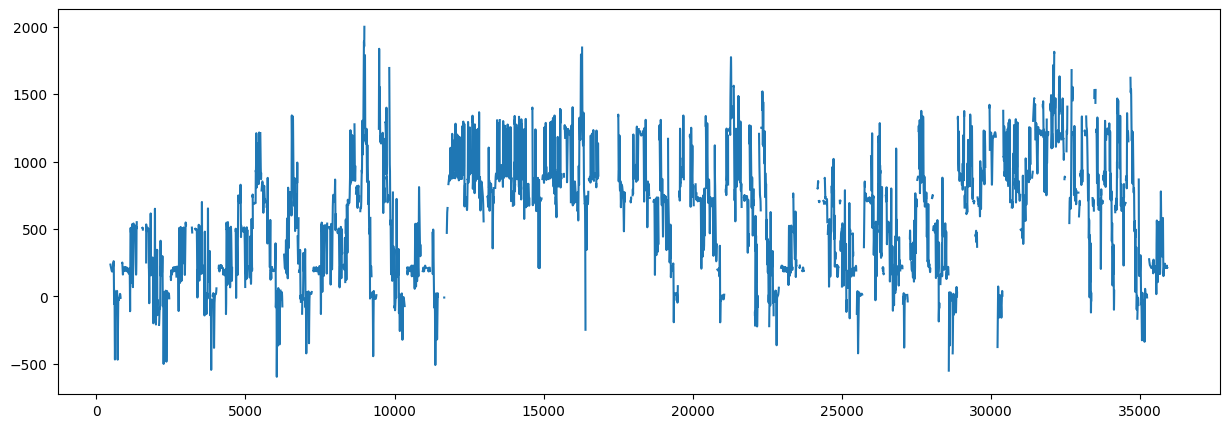

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(pitch)

## Segment

In [13]:
all_svaras = []

for i, row in annotations.iterrows():
    start = row['start_sec']
    end = row['end_sec']
    label = row['label']

    # Skip unknown labels
    if label not in svaras:
        continue
    
    s1_beat = start/beat_length
    s2_beat = end/beat_length
    
    s1 = round(s1_beat/timestep)
    s2 = round(s2_beat/timestep)

    psamp = pitch[s1:s2]
    psamp = remove_leading_trailing_nans(psamp)

    # Skip if there is silence in pitch track    
    if len(psamp) == 0 or len(psamp)/len(pitch[s1:s2]) <= min_len_prop or sum(np.isnan(psamp)>0):
        continue

    psamp, trans = transpose_pitch(psamp)

    ran = max(psamp)-min(psamp)
    
    # exclude incorrectly extracted time series
    if ran > max_ran:
        continue

    all_svaras.append((svaras.index(label), psamp, i, list(data.keys())[1]))

In [14]:
counted = Counter([x[0] for x in all_svaras])
for k,v in counted.items():
    print(f"{v} instances of {svaras[k]}")

65 instances of ri
78 instances of ni
57 instances of sa
59 instances of ga
41 instances of ma
62 instances of pa
83 instances of dha


In [15]:
n_max = max(counted.values())
for svara in range(len(svaras)):
    these_svaras = [x for x in all_svaras if x[0]==svara]
    if len(these_svaras) == 0:
        continue
    n = len(these_svaras)
    while n < n_max:
        this_svara = random.choice(these_svaras)
        all_svaras.append(this_svara)
        n += 1

In [16]:
counted = Counter([x[0] for x in all_svaras])
for k,v in counted.items():
    print(f"{v} instances of {svaras[k]}")

83 instances of ri
83 instances of ni
83 instances of sa
83 instances of ga
83 instances of ma
83 instances of pa
83 instances of dha


In [17]:
random.shuffle(all_svaras)

In [18]:
train_data = all_svaras[:round(train_size*len(all_svaras))]
test_data = all_svaras[round(train_size*len(all_svaras)):]

# DTW

In [19]:
samp = None
r = 0.3
norm = False

In [20]:
dtw_distances = list()

for i in tqdm.tqdm(list(range(len(all_svaras)))):
    for j in range(len(all_svaras)):
        jl, jpsamp, jannot_ix, jtrack = all_svaras[j]
        il, ipsamp, iannot_ix, itrack = all_svaras[i]

        if jl != il:
            continue

        if il > jl:
            continue

        l_longest = np.max([len(ipsamp), len(jpsamp)])
        radius = round(l_longest*r)
        
        if radius < 2:
            radius = 2

        # Compute DTW distance between ipsamp and jpsamp
        #path, distance = dtw_path(ipsamp, jpsamp, radius=radius, norm=norm)
        distance, path = fastdtw(ipsamp, jpsamp, dist=lambda x, y: np.linalg.norm(x - y))
        distance = distance/len(path)

        dtw_distances.append({
            'index1': j,
            'index2': i,
            'dtw': distance
        })

100%|█████████████████████████████████████████████████████████████████████████████████| 581/581 [03:03<00:00,  3.16it/s]


In [23]:
dtw_distances = pd.DataFrame(dtw_distances)
dtw_distances.head()

,index1,index2,dtw
0,0,0,0.000000
1,2,0,91.094975
2,8,0,37.352984
3,34,0,45.517291
4,36,0,63.338211


In [24]:
from bad import bad

In [25]:
allowed_indices = []
tested = []
for i in range(len(all_svaras)):
    j, psamp, annot_ix, track = all_svaras[i]
    t = f'{track}_{annot_ix}'
    if t not in tested and t not in bad:
        allowed_indices.append(i)
    tested.append(t)

In [26]:
distance_dict = {}
for i, (i1,i2,dist) in dtw_distances.iterrows():
    i1 = int(i1)
    i2 = int(i2)
    if i1 not in distance_dict:
        distance_dict[i1] = {}

    distance_dict[i1][i2] = dist

# Clustering

In [27]:
allowed_indices = []
tested = []
for i in range(len(all_svaras)):
    j, psamp, annot_ix, track = all_svaras[i]
    t = f'{track}_{annot_ix}'
    if t not in tested and t not in bad:
        allowed_indices.append(i)
    tested.append(t)

In [29]:
clust_data = {s:{} for s in svaras}
for svara in svaras:

    svara_ix = svaras.index(svara)

    # Get data for this svara
    ix = [i for i,x in enumerate(all_svaras) if x[0]==svara_ix and i in allowed_indices]

    clust_data[svara]['ix'] = ix

In [31]:
print('Clustering...')
clustering = {}
for svara in svaras:
    print(f'    Clustering svara {svara}')
    
    ix = clust_data[svara]['ix']
    

    X = all_X[ix, :][:, ix]
    X = sklearn.preprocessing.normalize(X)

    clus_labels = dbscan_precomp(X, **k)

    print(f'      n_clusters: {max(clus_labels)}')
    clustering[svara] = {'labels':clus_labels, 'ix':ix}

Clustering...
    Clustering svara sa


NameError: name 'all_X' is not defined